In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift, estimate_bandwidth

In [3]:
dataset = make_blobs(n_samples=10_000, centers=3, random_state=42)
total_samples = dataset[0].shape[0]
r_train, r_cal, r_test = 0.6, 0.2, 0.2
assert r_train + r_cal + r_test == 1
Z_train = dataset[0][: int(total_samples * r_train)]
Z_cal = dataset[0][
    int(total_samples * r_train) : int(total_samples * r_train)
    + int(total_samples * r_cal)
]
Z_test = dataset[0][int(total_samples * r_train) + int(total_samples * r_cal) :]
Z_eval = dataset[0][int(total_samples * r_train):]

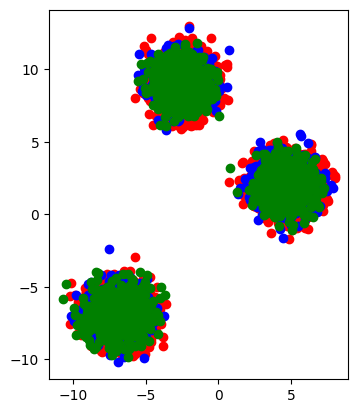

In [4]:
plt.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker="o", label="train")
plt.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker="o", label="cal")
plt.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker="o", label="test")
plt.gca().set_aspect("equal")

In [5]:
from conformal_region_designer.density_estimation import KDE
from conformal_region_designer.clustering import MeanShiftClustering
from conformal_region_designer.shapes import Ellipse
from conformal_region_designer.conformity_optimizer import ConformalRegion

In [6]:
DELTA = 0.95
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, Ellipse, DELTA)

In [7]:
pcr.fit(Z_train)

Generating density points
Fitting Clusters
Fitting Shapes
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=696509, Fri Nov 10 22:11:25 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.749342743270505e+01 1.0e+00 9.00e-01  9e-01  9e-01 0:00.0
    2     18 7.915128265695087e+01 1.3e+00 7.69e-01  7e-01  8e-01 0:00.1
    3     27 8.801825890980851e+01 1.3e+00 7.20e-01  7e-01  7e-01 0:00.1
   99    891 9.111669820002506e+00 3.2e+01 9.65e-02  1e-02  1e-01 0:03.1
  100    900 9.105406051681653e+00 3.6e+01 9.65e-02  1e-02  1e-01 0:03.2
  200   1800 9.088401835848529e+00 2.3e+03 6.34e-04  1e-04  1e-03 0:06.3
  300   2700 9.088398793408908e+00 1.4e+05 1.99e-06  5e-07  6e-06 0:09.4


/usr/local/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=336)
  warnings.warn(msg + ' (' +


  400   3600 9.088398793111708e+00 6.8e+00 2.40e-07  1e-07  3e-07 0:12.6
  500   4500 9.088398793141909e+00 1.7e+01 6.54e-07  1e-07  5e-07 0:16.1
  540   4860 9.088398793148066e+00 4.0e+01 1.24e-06  3e-07  9e-07 0:17.4
termination on tolstagnation=256 (Fri Nov 10 22:11:42 2023)
final/bestever f-value = 9.088399e+00 9.088399e+00 after 4861/3018 evaluations
incumbent solution: [-1.909842585795559, -6.517820912791649, 6.783374690829078, -1.7265011148474514, -2.3202561708021676, 8.942166848704801]
std deviation: [6.61548254993354e-07, 2.6181704472817826e-07, 5.125920667804251e-07, 8.72137926596414e-07, 6.13601684273762e-07, 4.937354536670479e-07]
[array([[49.66165248,  0.73647312],
       [ 0.73647312, 45.4628026 ]])]
[array([-2.32025559,  8.94216738])]
Soln time: 17.764306783676147
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=744281, Fri Nov 10 22:11:42 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 5.067160583405784e+01 1.0e+00 8.87e

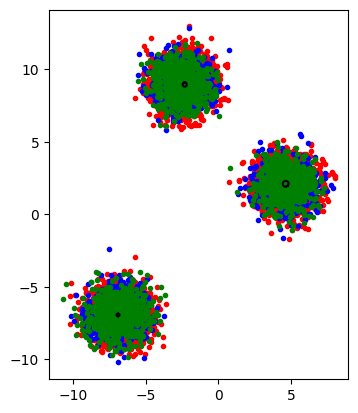

In [8]:
fig, ax = plt.subplots()
ax.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker=".", label="train")
ax.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)

In [9]:
pcr.conformalize(Z_cal, debug=True)

Target score: 0.3720637167421395


In [10]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
scores = pcr.calculate_scores(Z_cal)
coverage = np.sum(scores < 0) / len(scores)
print("Calibration Coverage: ", coverage)


Test Coverage:  0.9535
Calibration Coverage:  0.9505


(array([341., 168., 575., 792.,  79.,  25.,   7.,   8.,   4.,   1.]),
 array([-2.64103158e-03, -1.99947641e-03, -1.35792124e-03, -7.16366064e-04,
        -7.48108912e-05,  5.66744281e-04,  1.20829945e-03,  1.84985463e-03,
         2.49140980e-03,  3.13296497e-03,  3.77452014e-03]),
 <BarContainer object of 10 artists>)

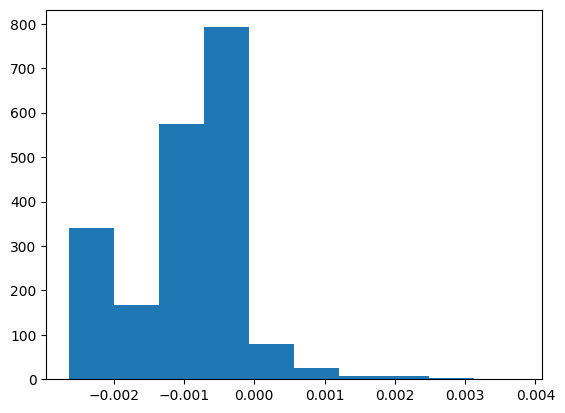

In [11]:
plt.hist(scores)

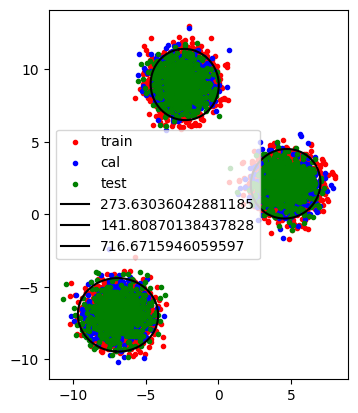

In [12]:
fig, ax = plt.subplots()
ax.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker=".", label="train")
ax.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax, label=shape_template.score_margin)
ax.legend()

In [22]:
from conformal_region_designer.utils import conformalized_quantile
target_quantile = conformalized_quantile(len(Z_train), DELTA)
print(target_quantile)

0.9501666666666667


In [23]:
# We need to do one hundred different splits of the data into calibration and test sets, to get a good estimate of the coverage.
# We will use the same training set for all splits.
from sklearn.model_selection import ShuffleSplit
from tqdm.autonotebook import tqdm
rs = ShuffleSplit(n_splits=1000, test_size=0.5, random_state=42)
rs.get_n_splits(Z_eval)
coverages = []
with tqdm(total=rs.get_n_splits(Z_eval)) as pbar:
    for cal_index, test_index in rs.split(Z_eval):
        Z_cal = Z_eval[cal_index]
        Z_test = Z_eval[test_index]
        pcr.conformalize(Z_cal)
        scores = pcr.calculate_scores(Z_test)
        coverage = np.sum(scores < 0) / len(scores)
        coverages.append(coverage)
        pbar.update(1)
        pbar.set_description(f"Coverage: {coverage:.0%}")
        # plt.close()
        # fig, ax = plt.subplots()
        # ax.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker=".", label="train")
        # ax.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker=".", label="cal")
        # ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
        # ax.set_aspect("equal")
        # for shape_template in pcr.shapes:
        #     shape_template.plot(ax, label=shape_template.score_margin)
        # ax.legend()
        # plt.show()

/tmp/ipykernel_169964/1002524400.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'Count')

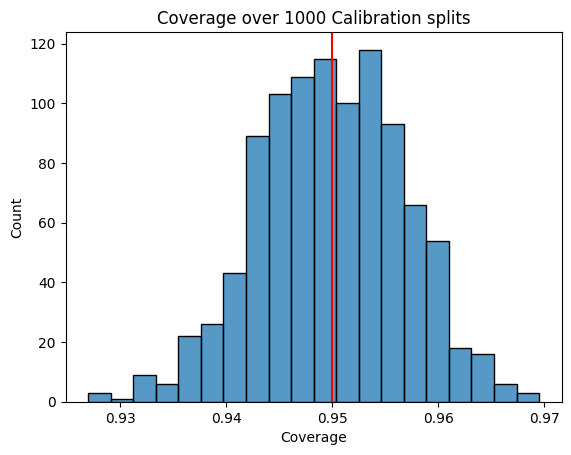

In [24]:
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red")
plt.title("Coverage over 1000 Calibration splits")
plt.xlabel("Coverage")
plt.ylabel("Count")